In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib
import os
import os 
import json
from datetime import datetime


In [4]:
df = pd.read_csv('../data/raw/baseline.csv')
feature_cols = [col for col in df.columns if col not in ['SHA', 'defect']]
X = df[feature_cols]
y = df['defect']

print(f"Features: {len(feature_cols)}")
print(f"Samples: {len(df)}")

Features: 21
Samples: 6052


In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTrain target distribution:\n{y_train.value_counts()}")
print(f"\nTest target distribution:\n{y_test.value_counts()}")

# Save train/test splits
os.makedirs('../data/processed', exist_ok=True)
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_df.to_csv('../data/processed/train.csv', index=False)
test_df.to_csv('../data/processed/test.csv', index=False)
print("Train/test splits saved!")


Train set: 4841 samples
Test set: 1211 samples

Train target distribution:
defect
1    2421
0    2420
Name: count, dtype: int64

Test target distribution:
defect
0    606
1    605
Name: count, dtype: int64
Train/test splits saved!


# Baseline Model 

In [6]:
baseline = DecisionTreeClassifier(random_state=42)
baseline.fit(X_train, y_train)

print(f"Baseline accuracy (train): {baseline.score(X_train, y_train):.4f}")
print(f"Baseline accuracy (test): {baseline.score(X_test, y_test):.4f}")
print(f"Baseline tree depth: {baseline.get_depth()}")
print(f"Baseline tree leaves: {baseline.get_n_leaves()}")


Baseline accuracy (train): 0.9818
Baseline accuracy (test): 0.6235
Baseline tree depth: 28
Baseline tree leaves: 1065


In [7]:
print("Starting GridSearchCV (this may take 2-3 minutes)...\n")

# Parameter grid
param_grid = {
    'max_depth': [4, 5, 6, 7, 8, 10],
    'min_samples_split': [10, 20, 30, 50],
    'min_samples_leaf': [5, 10, 15, 20],
    'criterion': ['gini', 'entropy']
}

# Grid search
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    dt, 
    param_grid, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n" + "="*60)
print("BEST PARAMETERS")
print("="*60)
print(grid_search.best_params_)
print(f"\nBest CV F1 Score: {grid_search.best_score_:.4f}")

# Best model
best_model = grid_search.best_estimator_


Starting GridSearchCV (this may take 2-3 minutes)...

Fitting 5 folds for each of 192 candidates, totalling 960 fits

BEST PARAMETERS
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 10}

Best CV F1 Score: 0.8000


c:\Users\Manas\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


# Evaluate Best Model 

MODEL EVALUATION

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       606
           1       0.75      0.79      0.77       605

    accuracy                           0.76      1211
   macro avg       0.76      0.76      0.76      1211
weighted avg       0.76      0.76      0.76      1211

ROC-AUC Score: 0.8035
 Confusion matrix saved!


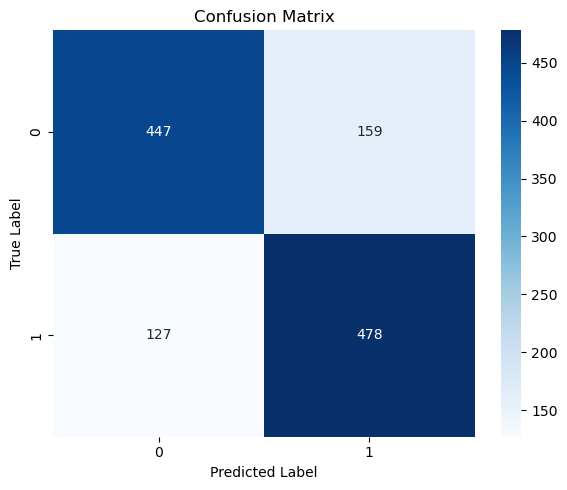

In [9]:
# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("="*60)
print("MODEL EVALUATION")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../reports/figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
print(" Confusion matrix saved!")
plt.show()


# ROC Curve

ROC curve saved!


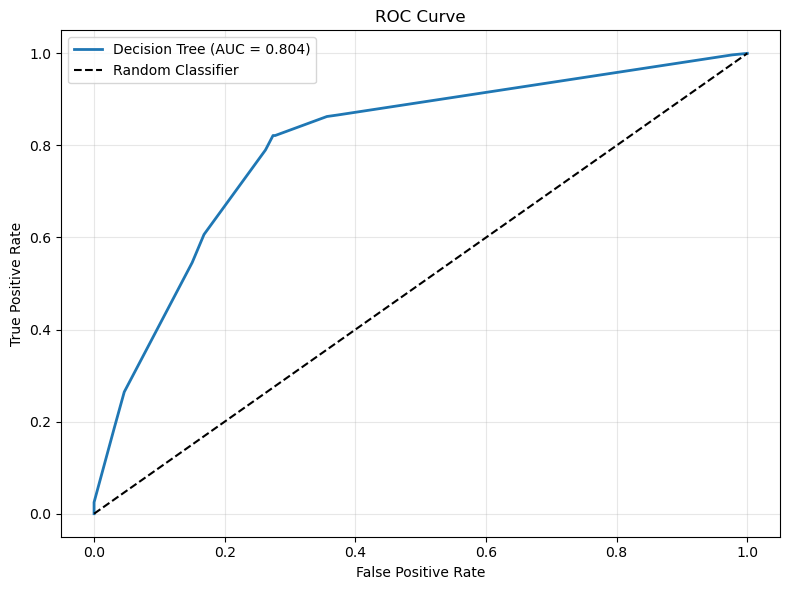

In [10]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/roc_curve.png', dpi=300, bbox_inches='tight')
print("ROC curve saved!")
plt.show()


# Feature Importance 

Top 15 Important Features:
              feature  importance
7                nosi    0.811798
16     assignmentsQty    0.072242
0                 cbo    0.042264
2                 dit    0.022373
3                 rfc    0.014295
17  mathOperationsQty    0.013027
14  stringLiteralsQty    0.008739
4                lcom    0.004842
5        totalMethods    0.003988
9           returnQty    0.003361
8                 loc    0.003071
19    maxNestedBlocks    0.000000
18       variablesQty    0.000000
15         numbersQty    0.000000
10            loopQty    0.000000
Feature importance plot saved!


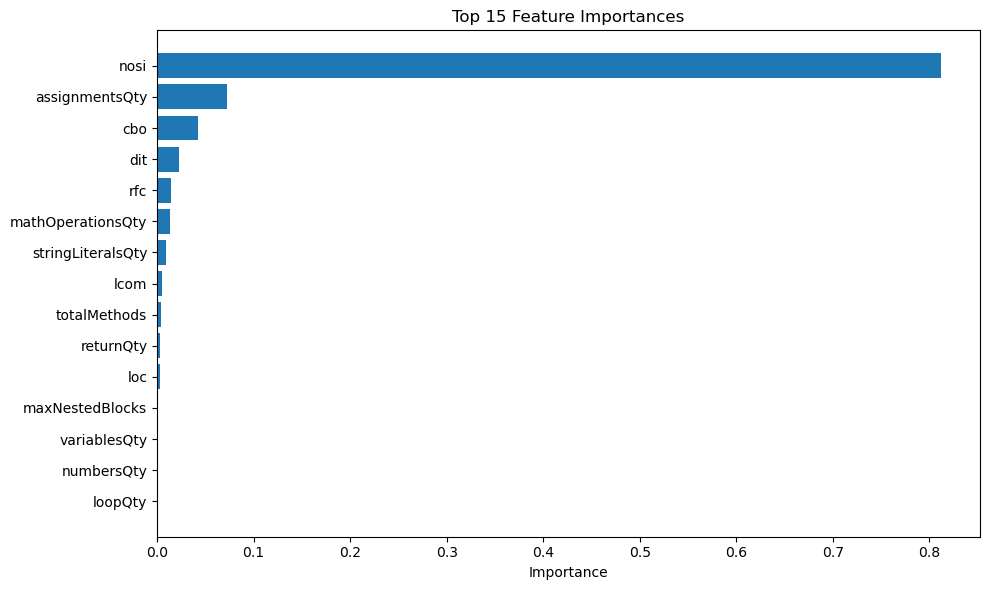

In [12]:
# Feature importance
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 15 Important Features:")
print(feature_importance_df.head(15))

# Plot
plt.figure(figsize=(10, 6))
top_15 = feature_importance_df.head(15)
plt.barh(range(len(top_15)), top_15['importance'])
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../reports/figures/feature_importance.png', dpi=300, bbox_inches='tight')
print("Feature importance plot saved!")
plt.show()


# Showing the Decision Tree Viz

Tree depth: 4
Number of leaves: 13
Decision tree visualization saved!


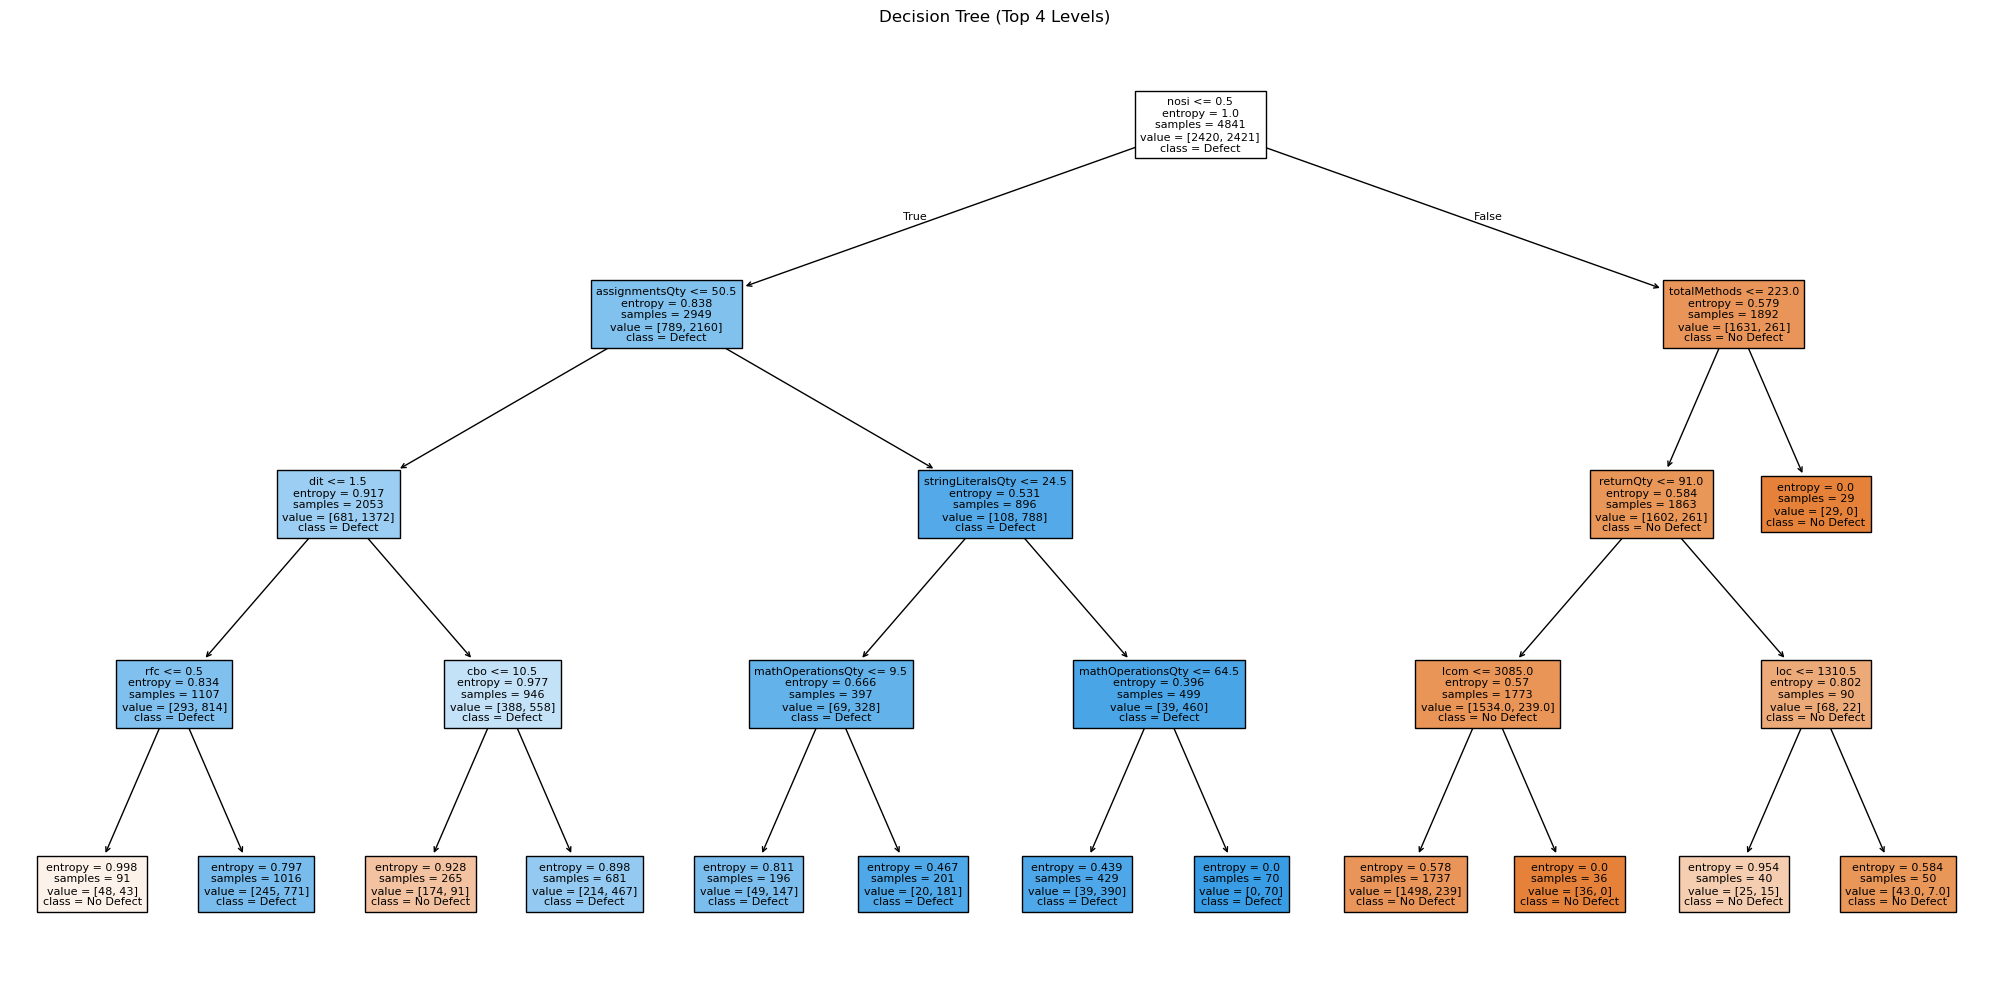

In [14]:
# Visualize tree (only if depth is reasonable)
tree_depth = best_model.get_depth()
print(f"Tree depth: {tree_depth}")
print(f"Number of leaves: {best_model.get_n_leaves()}")

if tree_depth <= 8:
    plt.figure(figsize=(20, 10))
    plot_tree(
        best_model, 
        feature_names=feature_cols,
        class_names=['No Defect', 'Defect'],
        filled=True,
        fontsize=8,
        max_depth=4  # Only show top 4 levels for clarity
    )
    plt.title('Decision Tree (Top 4 Levels)')
    plt.tight_layout()
    plt.savefig('../reports/figures/decision_tree.png', dpi=300, bbox_inches='tight')
    print("Decision tree visualization saved!")
    plt.show()
else:
    print("Tree too deep for full visualization, saved partial tree")


# Save Model

In [15]:
# Create models folder
os.makedirs('../models', exist_ok=True)

# Save model
model_path = '../models/decision_tree_model.pkl'
joblib.dump(best_model, model_path)
print(f"Model saved to: {model_path}")

# Save metadata
metadata = {
    'training_date': datetime.now().isoformat(),
    'best_params': grid_search.best_params_,
    'best_cv_score': float(grid_search.best_score_),
    'test_accuracy': float(best_model.score(X_test, y_test)),
    'test_roc_auc': float(roc_auc_score(y_test, y_proba)),
    'feature_columns': feature_cols,
    'model_type': 'DecisionTreeClassifier',
    'tree_depth': int(best_model.get_depth()),
    'n_leaves': int(best_model.get_n_leaves())
}

metadata_path = '../models/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Metadata saved to: {metadata_path}")


Model saved to: ../models/decision_tree_model.pkl
Metadata saved to: ../models/model_metadata.json


# Summary

In [18]:
print("\n" + "="*60)
print("MODEL TRAINING COMPLETE!")
print("="*60)
print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Test Accuracy: {best_model.score(X_test, y_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Tree Depth: {best_model.get_depth()}")
print(f"\nSaved artifacts:")
print(f"   - Model: models/decision_tree_model.pkl")
print(f"   - Metadata: models/model_metadata.json")
print(f"   - 4 visualizations in reports/figures/")



MODEL TRAINING COMPLETE!
Best Model Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 10}
Test Accuracy: 0.7638
ROC-AUC: 0.8035
Tree Depth: 4

Saved artifacts:
   - Model: models/decision_tree_model.pkl
   - Metadata: models/model_metadata.json
   - 4 visualizations in reports/figures/
